## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




**Ответ**  
Коллаборативная фильтрация: Рекомендации основаны на истории оценок как самого пользователя, так и других. Во втором случае системы рассматривают потребителей, оценки или интересы которых похожи на ваши.  
Гибридные системы:  
Есть несколько распространенных типов комбинирования:
реализация по отдельности коллаборативных и контентных алгоритмов и объединение их предположений;
включение некоторых контентных правил в коллаборативную методику;
включение некоторых коллаборативных правил в контентную методику;
построение общей модели, включающей в себя правила обеих методик.

Недостаток гибридных систем - высокая сложность (и соответсвенно время и стоимость) разработки.
по большому счету их имеет смысл  применять в крупных проектах с большим количеством пользователей:
- крупные интернет магазины
- сервисы типа Netflix
- случаи, когдабывает необходимо разнести данные по созданию user-item матрицы и аналогичных и непосредственно выдачу рекомендаций (первую часть можно выполнять оффлайн)   
Вообще, везде, где проблема "холодного старта" значима

2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

**Ответ**  
Двухуровневый парсинг резюме.   
Все, что добавлено дальше по тексту для улучшения производительности.  
Проблемы: Провалы по производительности и связанные с этим , как зависания системы в целом, так и выдача неподходящих рекомендаций. необходимость иметь достаточно мощный сервреный кластер.

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

1. MovieLens комбинированный с Tag Genome , CrossValidated
2. Для MovieLens tag-movie pair с учетом relevamce score, Crosss validated - positive/negative signal based on correcntess of answers. 
3. MF (Matrix Factorization)and CB (content based): LSI-LR, LSI-UP + Light FM with different sets of features.

## Практическая часть


In [1]:
import lightfm

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# import data
# utils functions like in webinar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
#from implicit.als import AlternatingLeastSquares
#from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

In [5]:
import seaborn as sns

In [3]:
data = pd.read_csv('retail_train.csv')

### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

**Answer:** src модуль не приложен к материалам ни одного урока. но в целом понятно, что имелось в виду. См. папку проект.

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

*Вообще непонятно какие внешние данные имеются в виду. взял датасет с вебинара.*

In [12]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


<AxesSubplot:>

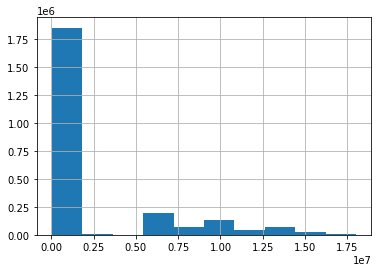

In [6]:
data['item_id'].hist()

<AxesSubplot:>

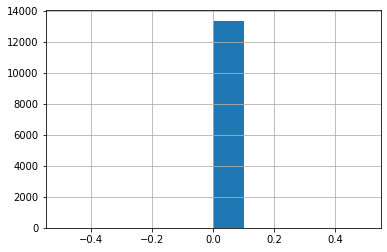

In [10]:
third = data['quantity'].quantile(q = 0.75)
data[data['quantity'] < third]['quantity'].hist()

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


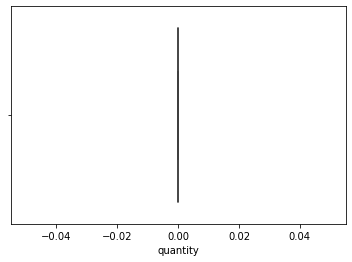

In [28]:
ax = sns.boxplot(data[(data['quantity'] < third) & (data['quantity'] >= 0)]['quantity'])

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


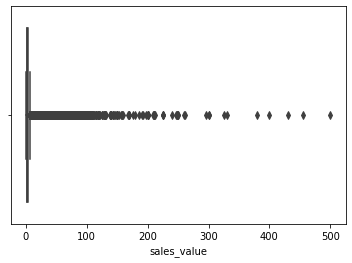

In [16]:
ax = sns.boxplot(data[data['sales_value'] < 500]['sales_value'])

### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 2%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*
